In [18]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [19]:
def spherical(h, nugget, range_, sill):
    """Spherical model of the semivariogram"""
    psill = sill - nugget
    return np.piecewise(h, [h <= range_, h > range_],
                        [lambda x: nugget + psill * ((3. * x) / (2. * range_) - (x**3.) / (2 * range_**3.)),
                         sill])

In [20]:
tmin = -9999.; tmax = 9999.
lag_dist = 1000; lag_tol = 7; nlag = 10;
bandh = 9999.9; atol = 22.5
isill = 1

major_guess = 90
minor_guess = 0
    
azi_mat = [major_guess, minor_guess]

filename_list = [f.path.split('/')[-1] for f in os.scandir('dataset/') if(f.is_dir() and f.path.split('/')[-1]!='.ipynb_checkpoints' and f.path.split('/')[-1]!='vardump')]

# COLOR BYPASS
cmap = 'inferno'

# Get the 'inferno' colormap
cmap = cm.get_cmap(cmap)

# Get the first and last colors
#---BYPASSED
#start_color = cmap(0)
#end_color = cmap(1)

start_color = (245/255, 125/255, 21/255)  # RGB: (245, 125, 21)
end_color = (101/255, 21/255, 110/255)  # RGB: (101, 21, 110)

/tmp/ipykernel_26106/1811343271.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


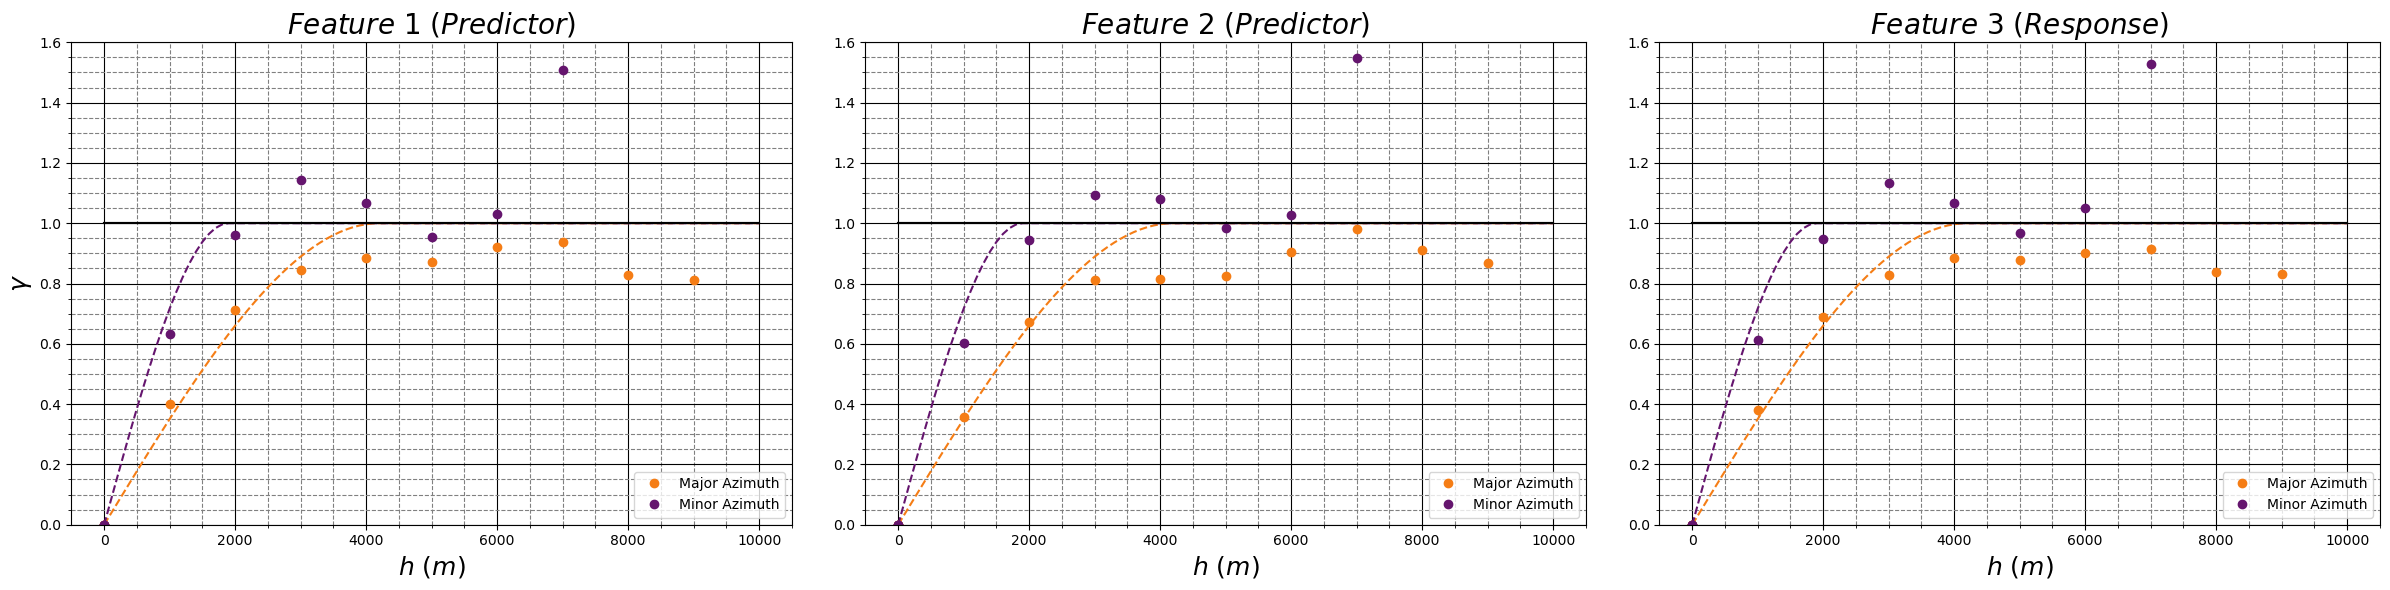

In [21]:
for filename in filename_list:
    df = pd.read_csv('dataset/' + filename + '/' + filename + '.csv')
    df = df[(df.x%2==0) & (df.y%2==0)]

    with open('dataset/' + filename + '/' + filename + '_var_params_and_n_eff.json', 'r') as f:
        var_dict = json.load(f)
    

    predictors = df.iloc[:,2:-1].columns.values
    response = df.columns[-1]
    predictors_and_response = df.iloc[:,2:].columns.values
    num_predictors_and_response = predictors_and_response.shape[0]

    df_train, df_test = train_test_split(df, test_size=0.5, random_state=73073)
    X_train = df_train.loc[:, predictors].values
    y_train = df_train.loc[:, response].values
    X_test = df_test.loc[:, predictors].values
    y_test = df_test.loc[:, response].values
    
    # Figure for variogram plots
    fig1, axs1 = plt.subplots(1, num_predictors_and_response, figsize=(24,6))

    for i in range(num_predictors_and_response):
        column = predictors_and_response[i]

        # Variogram plot
        ax1 = axs1[i]
        for idx_azi in range(len(azi_mat)):
            lag, gamma, npp = geostats.gamv(df_train,'x','y',predictors_and_response[i],tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[idx_azi],atol,bandh,isill)
            distances = np.arange(0.0, 10001, 100, dtype='float')
            nugget = var_dict['nug']
            sill = 1.0
            
            if(azi_mat[idx_azi]==major_guess):
                ax1.plot(lag, gamma,'o',label = 'Major Azimuth', color=start_color)
                range_ = var_dict['hmaj1']
                ax1.plot(distances, spherical(distances, nugget, range_, sill), '--', color=start_color)
            elif(azi_mat[idx_azi]==minor_guess):
                ax1.plot(lag, gamma,'o',label = 'Minor Azimuth', color=end_color)
                
                range_ = var_dict['hmin1']
                ax1.plot(distances, spherical(distances, nugget, range_, sill), '--', color=end_color)
            else:
                ax1.plot(lag, gamma,'x',label = 'Azimuth ' +str(azi_mat[idx_azi]))
                
            ax1.plot([0,lag_dist * nlag],[1.0,1.0],color = 'black')
            ax1.set_xlabel(r'$h\ (m)$', fontsize=18)
            if(i==0):
                ax1.set_ylabel(r'$γ$', fontsize=18)
            ax1.set_ylim([0,1.6])
            # Set the title
            if(num_predictors_and_response-i==1):
                ax1.set_title(fr'$Feature\ {i+1}\ (Response)$', fontsize=20)
            else:
                ax1.set_title(fr'$Feature\ {i+1}\ (Predictor)$', fontsize=20)
            
            ax1.legend(loc='lower right')
            ax1.grid(visible=True, which='major', color='black', linestyle='-')
            ax1.grid(visible=True, which='minor', color='gray', linestyle='--')
            ax1.minorticks_on()

            
    plt.tight_layout(h_pad=2.0, w_pad=3.0)
    plt.savefig(f'dataset/{filename}/{filename}_variograms.png', dpi=600)

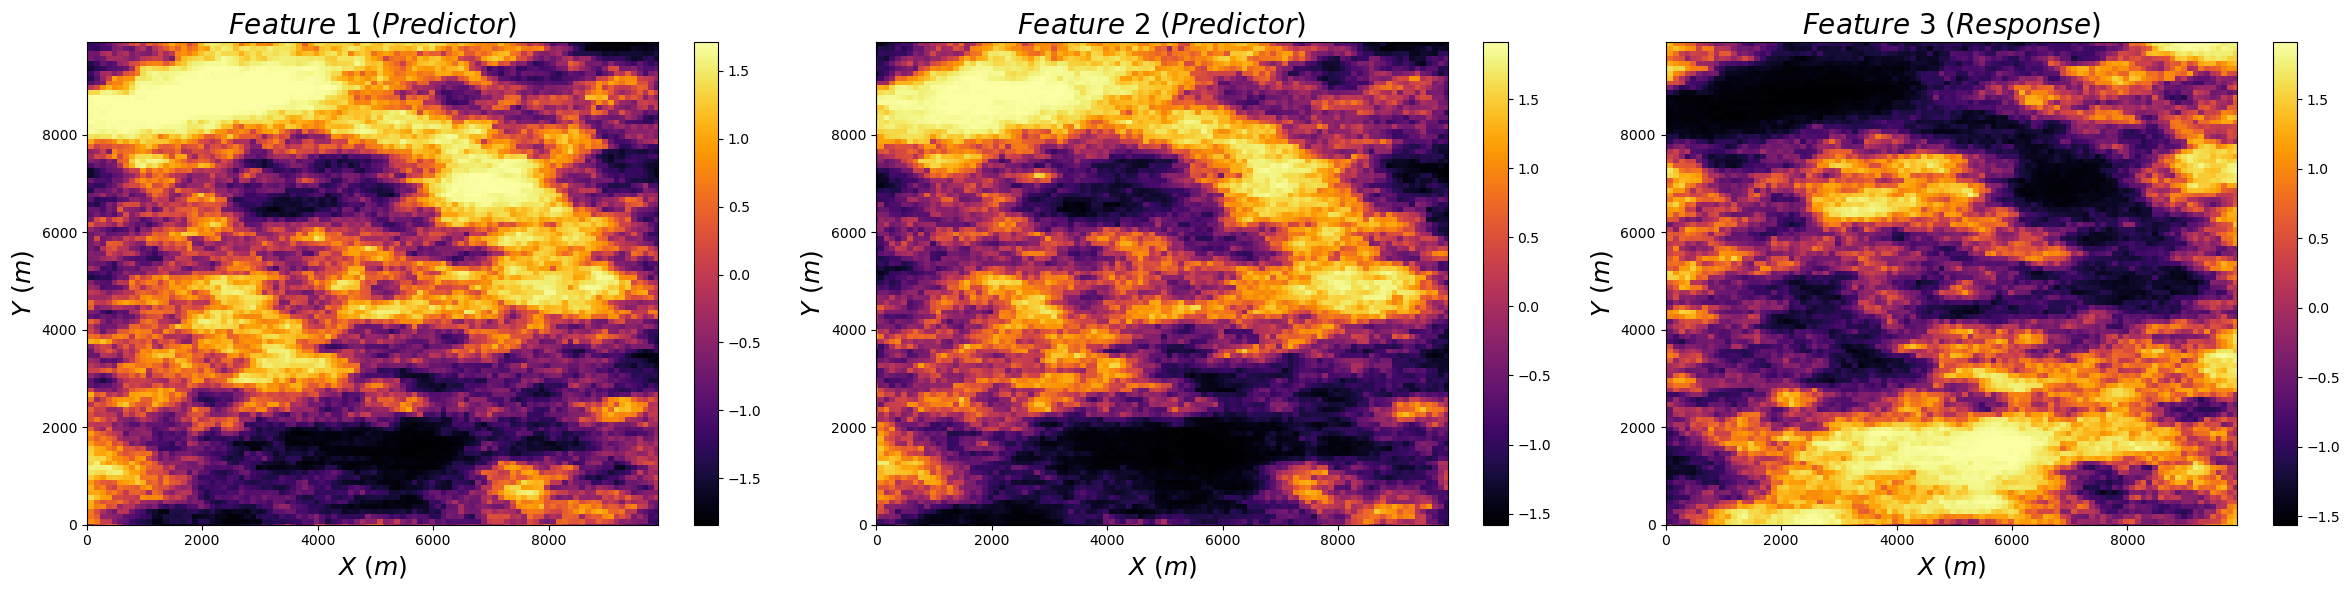

In [22]:
for filename in filename_list:
    df = pd.read_csv('dataset/' + filename + '/' + filename + '.csv')
    df = df[(df.x%2==0) & (df.y%2==0)]

    predictors = df.iloc[:,2:-1].columns.values
    response = df.columns[-1]
    predictors_and_response = df.iloc[:,2:].columns.values
    num_predictors_and_response = predictors_and_response.shape[0]

    df_train, df_test = train_test_split(df, test_size=0.5, random_state=73073)
    X_train = df_train.loc[:, predictors].values
    y_train = df_train.loc[:, response].values
    X_test = df_test.loc[:, predictors].values
    y_test = df_test.loc[:, response].values

    # Figure for pixel plots
    fig2, axs2 = plt.subplots(1, num_predictors_and_response, figsize=(24,6))

    for i in range(num_predictors_and_response):
        column = predictors_and_response[i]

        # Pixel plot
        ax2 = axs2[i]
        ax2.margins(0)
        # Create a scatter plot with color determined by the predictor/response
        scatter = ax2.scatter(df['x'], df['y'], c=df[column].values, s=35,cmap=cmap, marker='s', edgecolors='none')
        
        # Remove axes spines
        for spine in ax2.spines.values():
            spine.set_visible(True)

        # Set the title
        if(num_predictors_and_response-i==1):
            ax2.set_title(fr'$Feature\ {i+1}\ (Response)$', fontsize=20)
        else:
            ax2.set_title(fr'$Feature\ {i+1}\ (Predictor)$', fontsize=20)
            
        # Set the labels
        ax2.set_xlabel(r'$X\ (m)$', fontsize=18)
        ax2.set_ylabel(r'$Y\ (m)$', fontsize=18)

        # Add a colorbar
        fig2.colorbar(scatter, ax=ax2, location='right')

    plt.tight_layout(h_pad=2.0, w_pad=1.0)
    plt.savefig(f'dataset/{filename}/{filename}_locmaps.png', dpi=600)
    plt.show()